In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import time
import math

from datetime import datetime

## Stock Prices

In [2]:
STOCK_PRICES_DATE_COL = 'Date'
STOCK_PRICES_HIGH_COL = 'High'
STOCK_PRICES_LOW_COL = 'Low'
STOCK_PRICES_AVG_COL = 'Avg'

def load_stock_prices(path):
  stock_prices = pd.read_csv(path)
  stock_prices[STOCK_PRICES_DATE_COL] = pd.to_datetime(stock_prices[STOCK_PRICES_DATE_COL])
  stock_prices[STOCK_PRICES_AVG_COL] = ((stock_prices[STOCK_PRICES_HIGH_COL] + stock_prices[STOCK_PRICES_LOW_COL]) / 2)
  stock_prices = stock_prices.set_index(STOCK_PRICES_DATE_COL)

  return stock_prices

In [3]:
SPX_PRICES_FILE_PATH = 'spx_index_prices.csv'
STOCK_PRICES = load_stock_prices(SPX_PRICES_FILE_PATH)
STOCK_PRICES

,Open,High,Low,Close,Adj Close,Volume,Avg
Date,,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000,1458.179993
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000,1426.325012
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000,1395.475037
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000,1402.000000
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000,1421.099976
...,...,...,...,...,...,...,...
2020-03-16,2508.590088,2562.979980,2380.939941,2386.129883,2386.129883,7781540000,2471.959961
2020-03-17,2425.659912,2553.929932,2367.040039,2529.189941,2529.189941,8358500000,2460.484986
2020-03-18,2436.500000,2453.570068,2280.520020,2398.100098,2398.100098,8755780000,2367.045044


## Option Prices

In [4]:
OPTION_PRICES_DATE_COL = 'date'
OPTION_PRICES_EXPIRATION_COL = 'exdate'
OPTION_PRICES_MATURITY_COL = 'maturity'
OPTION_PRICES_STRIKE_COL = 'strike_price'
OPTION_PRICES_BID_COL = 'best_bid'
OPTION_PRICES_OFFER_COL = 'best_offer'
OPTION_PRICES_SPREAD_COL = 'spread'
OPTION_PRICES_AVG_COL = 'avg'
OPTION_PRICES_ID_COL = 'optionid'
OPTION_PRICES_DATE_FMT = '%Y%m%d'
OPTION_PRICES_OTM_RANGE = 'otm_range'

def load_option_prices(path):
  option_prices = pd.read_csv(SPX_OPTION_PRICES_FILE_PATH);
  option_prices[OPTION_PRICES_DATE_COL] = pd.to_datetime(
      option_prices[OPTION_PRICES_DATE_COL],
      format=OPTION_PRICES_DATE_FMT)
  option_prices[OPTION_PRICES_EXPIRATION_COL] = pd.to_datetime(
      option_prices[OPTION_PRICES_EXPIRATION_COL],
      format=OPTION_PRICES_DATE_FMT)
  option_prices[OPTION_PRICES_STRIKE_COL] = option_prices[OPTION_PRICES_STRIKE_COL].div(1000)
  option_prices[OPTION_PRICES_MATURITY_COL] = (
    option_prices[OPTION_PRICES_EXPIRATION_COL] - 
    option_prices[OPTION_PRICES_DATE_COL]
  ).dt.days
  option_prices[OPTION_PRICES_SPREAD_COL] = (
    option_prices[OPTION_PRICES_OFFER_COL] - 
    option_prices[OPTION_PRICES_BID_COL]
  )
  option_prices[OPTION_PRICES_AVG_COL] = (
    (
      option_prices[OPTION_PRICES_OFFER_COL] +
      option_prices[OPTION_PRICES_BID_COL]
    ) / 2
  )

  return option_prices

In [5]:
SPX_OPTION_PRICES_FILE_PATH = 'spx_option_prices.csv'
OPTION_PRICES = load_option_prices(SPX_OPTION_PRICES_FILE_PATH)
OPTION_PRICES

,secid,date,exdate,last_date,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,...,vega,theta,optionid,forward_price,index_flag,issuer,exercise_style,maturity,spread,avg
0,108105,2000-01-03,2000-03-18,19991229.0,P,1410.0,36.750,38.750,0,1,...,235.99500,-119.41110,10120210,1470.521157,1,CBOE S&P 500 INDEX,E,75,2.0,37.750
1,108105,2000-01-03,2000-01-22,19991223.0,P,1505.0,55.250,57.250,0,50,...,100.89450,-172.62950,10000760,1458.650389,1,CBOE S&P 500 INDEX,E,19,2.0,56.250
2,108105,2000-01-03,2000-06-17,20000103.0,P,1350.0,40.750,42.750,290,14570,...,311.57080,-66.86736,10016917,1490.761534,1,CBOE S&P 500 INDEX,E,166,2.0,41.750
3,108105,2000-01-03,2000-01-22,20000103.0,P,1500.0,51.625,53.625,57,505,...,105.71350,-186.79210,10149633,1458.650389,1,CBOE S&P 500 INDEX,E,19,2.0,52.625
4,108105,2000-01-03,2000-01-22,NaN,P,1540.0,84.875,86.875,0,0,...,68.56206,-96.37443,10056576,1458.650389,1,CBOE S&P 500 INDEX,E,19,2.0,85.875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8462523,108105,2019-06-28,2020-06-30,NaN,P,3800.0,824.100,848.000,0,0,...,NaN,NaN,129500433,2942.162769,1,CBOE S&P 500 INDEX,E,368,23.9,836.050
8462524,108105,2019-06-28,2020-06-30,NaN,P,3900.0,921.200,945.200,0,0,...,NaN,NaN,129500434,2942.162769,1,CBOE S&P 500 INDEX,E,368,24.0,933.200
8462525,108105,2019-06-28,2020-06-30,NaN,P,4000.0,1018.700,1042.500,0,0,...,NaN,NaN,129500435,2942.162769,1,CBOE S&P 500 INDEX,E,368,23.8,1030.600
8462526,108105,2019-06-28,2020-06-30,NaN,P,4100.0,1116.100,1140.000,0,0,...,NaN,NaN,129500436,2942.162769,1,CBOE S&P 500 INDEX,E,368,23.9,1128.050


## Algorithm


In [6]:
## Portfolio Log

PORTFOLIO_DATE = 'portfolio_date'
PORTFOLIO_CASH = 'portfolio_cash'
PORTFOLIO_STOCK_QUANTITY = 'portfolio_stock_quantity'
PORTFOLIO_OPTION_QUANTITY = 'portfolio_option_quantity'
PORTFOLIO_OPTION_ID = 'portfolio_option_id'

def build_portfolio_log(): 
    portfolio_log = pd.DataFrame(
        columns=[
            PORTFOLIO_DATE,
            PORTFOLIO_CASH,
            PORTFOLIO_STOCK_QUANTITY,
            PORTFOLIO_OPTION_QUANTITY,
            PORTFOLIO_OPTION_ID,
        ]
    )
    portfolio_log.index = portfolio_log[PORTFOLIO_DATE]

    return portfolio_log

def build_portfolio_row(
    date, 
    cash, 
    stock_quantity, 
    option_quantity,
    option_id):
    return pd.Series({
        PORTFOLIO_DATE: date,
        PORTFOLIO_CASH: cash,
        PORTFOLIO_STOCK_QUANTITY: stock_quantity,
        PORTFOLIO_OPTION_QUANTITY: option_quantity,
        PORTFOLIO_OPTION_ID: option_id,
    })

In [7]:
## Goal 

GOAL_GET_STOCK_ALLOC = 'get_stock_alloc'
GOAL_OTM_RANGE = 'otm_range'
GOAL_MATURITY_RANGE = 'maturity_range'

def build_goal(get_stock_alloc, otm_range, maturity_range):
    return {
        GOAL_GET_STOCK_ALLOC: get_stock_alloc, 
        GOAL_OTM_RANGE: otm_range, 
        GOAL_MATURITY_RANGE: maturity_range
    }

In [8]:
## Stocks: Sell

def get_stock_price(date):
    return STOCK_PRICES.loc[date][STOCK_PRICES_AVG_COL]

def liquidate_stock(portfolio_row):
    stock_quantity = portfolio_row[PORTFOLIO_STOCK_QUANTITY]
    if not stock_quantity:
        return 0

    return stock_quantity * get_stock_price(portfolio_row[PORTFOLIO_DATE])


In [33]:
## Options: sell

def get_option_row(date, option_id):
    options_for_date = OPTION_PRICES[OPTION_PRICES[OPTION_PRICES_DATE_COL] == date]
    options_with_id = options_for_date[options_for_date[OPTION_PRICES_ID_COL] == option_id]
    if (options_with_id.shape[0] != 1):
        raise SystemExit("Uh oh, expected to find one option row date = {} option_id = {}".format(date, option_id))

    return options_with_id.iloc[0]

def get_option_sell_price(row):
    return row[OPTION_PRICES_BID_COL]

def liquidate_option(portfolio_row):
    option_id = portfolio_row[PORTFOLIO_OPTION_ID]
    if not option_id:
        return 0

    return (
        portfolio_row[PORTFOLIO_OPTION_QUANTITY] * 
        get_option_sell_price(
            get_option_row(portfolio_row[PORTFOLIO_DATE], option_id)
        )
    )

In [32]:
## Options: Buy

def get_option_buy_price(row):
    return row[OPTION_PRICES_OFFER_COL]
    
def options_for_otm_range(date, options, otm_range):
  current_stock_price = get_stock_price(date)
  min_strike = (1 - otm_range[1]) * current_stock_price
  max_strike = (1 - otm_range[0]) * current_stock_price
  
  return options[
    options[OPTION_PRICES_STRIKE_COL].between(min_strike, max_strike)
  ]

def find_potential_option_rows_to_buy(date, otm_range, maturity_range):
  options_on_this_date = OPTION_PRICES[OPTION_PRICES[OPTION_PRICES_DATE_COL] == date]
  options_within_expiration_range = options_on_this_date[
    options_on_this_date[OPTION_PRICES_MATURITY_COL]
      .between(maturity_range[0], maturity_range[1])
  ]
  options_within_otm_range = options_for_otm_range(
    date,
    options_within_expiration_range,
    otm_range
  )
  options_sorted_by_lowest_price_at_highest_strike = options_within_otm_range.sort_values(
    by=[OPTION_PRICES_OFFER_COL, OPTION_PRICES_STRIKE_COL], 
    ascending=[True, False]
  )
  
  return options_sorted_by_lowest_price_at_highest_strike

def get_option_row_to_buy(date, otm_range, maturity_range):
  best_option_rows = find_potential_option_rows_to_buy(date, otm_range, maturity_range)
  if best_option_rows.empty:
    raise SystemExit("wasn't able to find an option for {}".format(date))
  
  return best_option_rows.iloc[0]

In [11]:
## Liquidation

def liquidate_portfolio(portfolio_row):
  return (
      portfolio_row[PORTFOLIO_CASH] + 
      liquidate_stock(portfolio_row) + 
      liquidate_option(portfolio_row)
  )

In [12]:
## Purchase

def purchase(cash_available, price_per_item):
  quantity = cash_available // price_per_item
  return (quantity, quantity * price_per_item)

In [13]:
## Algo: Trade at a specific date

def trade_portfolio(
    current_portfolio_row,
    stock_alloc,
    option_row):
  date = current_portfolio_row[PORTFOLIO_DATE]
  cash_available = liquidate_portfolio(current_portfolio_row)
  stock_cash = cash_available * stock_alloc
  option_cash = cash_available - stock_cash
  
  (stock_quantity, stock_cash_used) = purchase( 
      stock_cash,
      get_stock_price(date)
  )

  (option_quantity, option_cash_used) = purchase(
      option_cash,
      get_option_buy_price(option_row),
  )

  return build_portfolio_row(
      date=current_portfolio_row[PORTFOLIO_DATE],
      cash=(cash_available - (stock_cash_used + option_cash_used)),
      stock_quantity=stock_quantity,
      option_quantity=option_quantity,
      option_id=option_row[OPTION_PRICES_ID_COL],
  )

In [14]:
## give an option row, decides when to next schedule a trade 
def get_next_trading_date(option_row):
   option_rows_with_this_id = OPTION_PRICES[
       OPTION_PRICES[OPTION_PRICES_ID_COL] == option_row[OPTION_PRICES_ID_COL]]
   start_date = option_row[OPTION_PRICES_DATE_COL]
   end_date = option_row[OPTION_PRICES_EXPIRATION_COL]
   available_days = pd.bdate_range(start=start_date, end=end_date).intersection(
       option_rows_with_this_id[OPTION_PRICES_DATE_COL]
   )

   return available_days[len(available_days) // 2]

In [15]:
def trade(cash, goal, start_date):
    log = build_portfolio_log()
    
    portfolio_row = build_portfolio_row(start_date, cash, 0, 0, None)
    last_possible_date = OPTION_PRICES.iloc[len(OPTION_PRICES) - 1][OPTION_PRICES_DATE_COL]
    while True:
       date = portfolio_row[PORTFOLIO_DATE]
       stock_alloc = goal[GOAL_GET_STOCK_ALLOC](date)
       best_option_to_buy = get_option_row_to_buy(date, goal[GOAL_OTM_RANGE], goal[GOAL_MATURITY_RANGE])
       
       portfolio_row = trade_portfolio(portfolio_row, stock_alloc, best_option_to_buy)
       
       log.loc[date] = portfolio_row
       
       next_date = get_next_trading_date(best_option_to_buy)

       if next_date >= last_possible_date:
           return log
       
       portfolio_row = portfolio_row.copy()
       portfolio_row[PORTFOLIO_DATE] = next_date

## Analysis

In [37]:
ANALYSIS_TOTAL_VALUE = 'analysis_total_value'
ANALYSIS_STOCK_VALUE = 'analysis_stock_value'
ANALYSIS_OPTION_VALUE = 'analysis_option_value'
ANALYSIS_STOCK_PERCENT = 'analysis_stock_percent'
ANALYSIS_OPTION_PERCENT = 'analysis_option_percent'
ANALYSIS_CASH_PERCENT = 'analysis_cash_percent'
ANALYSIS_OTM = 'analysis_otm'

def otm_value(strike_price, stock_price):
    return 1 - strike_price / stock_price

def analyze_rows(log):
    def row_for_analysis(portfolio_row): 
        option_row = get_option_row(
            portfolio_row[PORTFOLIO_DATE], portfolio_row[PORTFOLIO_OPTION_ID]
        )
        total_value = liquidate_portfolio(portfolio_row)
        stock_value = liquidate_stock(portfolio_row)
        option_value = liquidate_option(portfolio_row)
        cash_value = portfolio_row[PORTFOLIO_CASH]
        analysis_row = pd.Series({
            ANALYSIS_TOTAL_VALUE: total_value,
            ANALYSIS_STOCK_VALUE: stock_value,
            ANALYSIS_OPTION_VALUE: option_value,
            ANALYSIS_STOCK_PERCENT: stock_value / total_value,
            ANALYSIS_OPTION_PERCENT: option_value / total_value,
            ANALYSIS_CASH_PERCENT: cash_value / total_value,
            ANALYSIS_OTM: otm_value(
                option_row[OPTION_PRICES_STRIKE_COL], 
                get_stock_price(portfolio_row[PORTFOLIO_DATE])
            )
        })

        return pd.concat([portfolio_row, option_row, analysis_row])


    return log.apply(row_for_analysis, axis=1)

BENCHMARK_STOCK_VALUE = 'benchmark_stock_quantity'
BENCHMARK_STOCK_QUANTITY = 'benchmark_stock_quantity'
BENCHMARK_TOTAL_VALUE = 'benchmark_total_value'
BENCHMARK_CASH = 'benchmark_cash'

def add_benchmark_data(rows):
    first_row = rows.iloc[0]
    cash = liquidate_portfolio(first_row)

    (benchmark_quantity, cash_used) = purchase(
        cash, get_stock_price(first_row[PORTFOLIO_DATE])
    )
    cash_avail = cash - cash_used
    
    def add_benchmark_data(row):
        stock_value = benchmark_quantity * get_stock_price(row[PORTFOLIO_DATE])
        return pd.concat([row, pd.Series({
            BENCHMARK_STOCK_VALUE: stock_value,
            BENCHMARK_STOCK_QUANTITY: benchmark_quantity,
            BENCHMARK_TOTAL_VALUE: stock_value + cash_avail,
            BENCHMARK_CASH: cash_avail
        })])
    
    return rows.apply(add_benchmark_data, axis=1)

def graph(brows):
    plt.plot(brows[ANALYSIS_STOCK_PERCENT])
    plt.title("Stock Percent")
    plt.show()
    plt.plot(brows[ANALYSIS_OPTION_PERCENT])
    plt.title("Stock Option Percent")
    plt.show()
    plt.title("Maturity Range")
    plt.plot(brows[OPTION_PRICES_MATURITY_COL])
    plt.show()
    plt.title("OTM Values")
    plt.plot(brows[ANALYSIS_OTM])
    plt.show()
    plt.title("Bid Price")
    plt.plot(brows[OPTION_PRICES_BID_COL])
    plt.show()
    plt.title("Offer Price")
    plt.plot(brows[OPTION_PRICES_OFFER_COL])
    plt.show()
    plt.title("Option Value")
    plt.plot(brows[ANALYSIS_OPTION_VALUE])
    plt.show()
    plt.title("Comparison")
    plt.plot(brows[BENCHMARK_TOTAL_VALUE], label=BENCHMARK_TOTAL_VALUE)
    plt.plot(brows[ANALYSIS_TOTAL_VALUE], label=ANALYSIS_TOTAL_VALUE)
    plt.plot(brows[ANALYSIS_STOCK_VALUE], label=ANALYSIS_STOCK_VALUE)
    plt.plot(brows[ANALYSIS_OPTION_VALUE], label=ANALYSIS_OPTION_VALUE)
    plt.plot(brows[PORTFOLIO_CASH], label=PORTFOLIO_CASH)
    plt.show()

    return

def trade_and_analyze(cash, goal, start_date):
    log = trade(cash, goal, start_date)
    arows = analyze_rows(log)
    brows = add_benchmark_data(arows)
    
    graph(brows)
    
    return brows

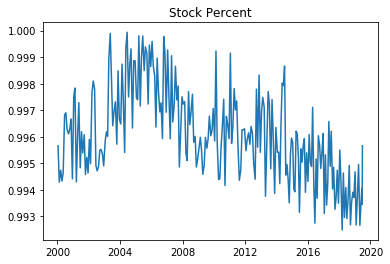

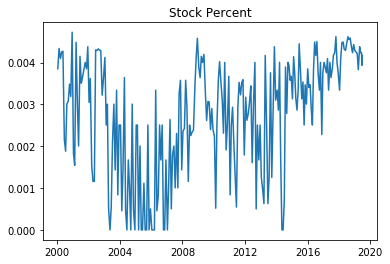

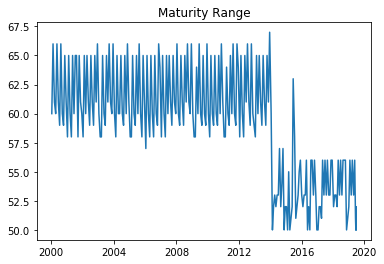

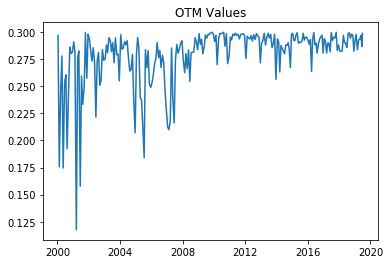

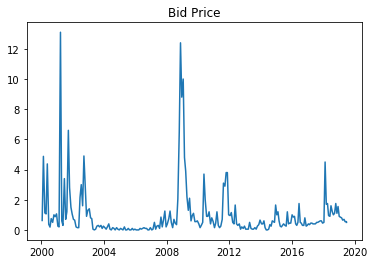

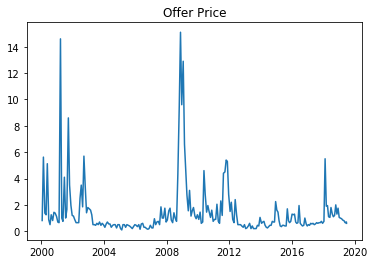

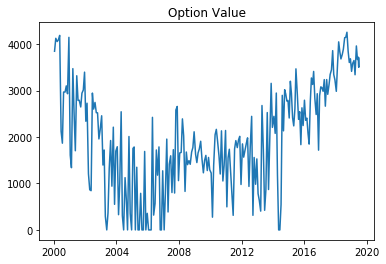

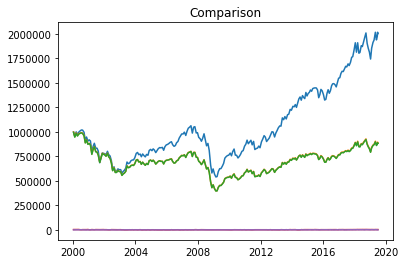

In [39]:
a = trade_and_analyze(
    1000000, 
    build_goal(get_stock_alloc=lambda _x: 0.995, otm_range=(0.1, 0.3), maturity_range=(50, 70)),
    datetime(2000, 1, 18)
)

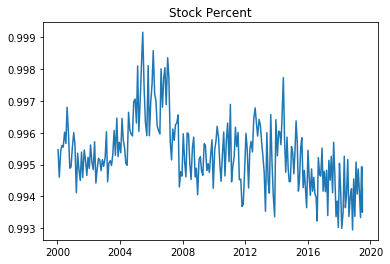

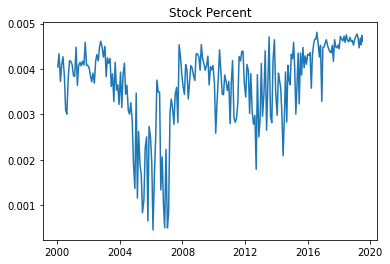

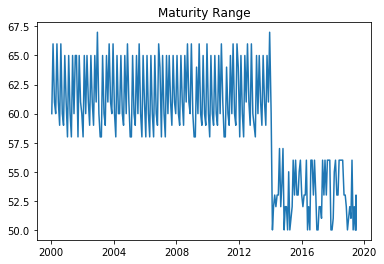

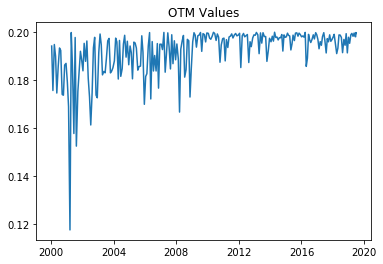

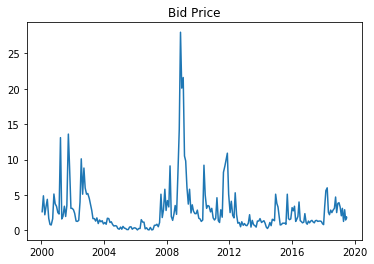

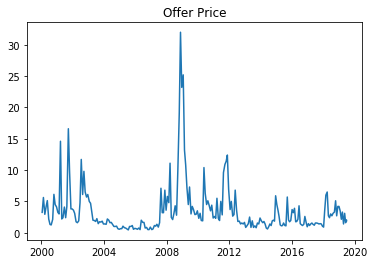

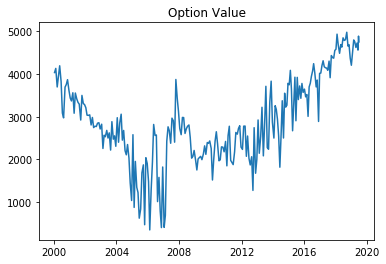

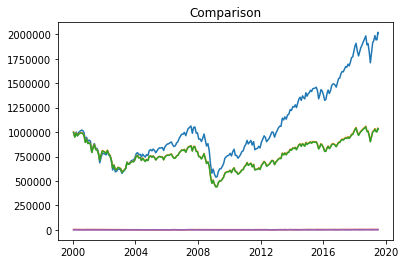

In [40]:
b = trade_and_analyze(
    1000000, 
    build_goal(get_stock_alloc=lambda _x: 0.995, otm_range=(0.1, 0.2), maturity_range=(50, 70)),
    datetime(2000, 1, 18)
)

## Investigation

When you look at the option value, you can see how there aren't real "jumps" in value. I would expect 10x + jumps during significant drawdowns. A bit surprising that we don't see that